# Detect (with the) Model
## Step 1 - run the TENSORFLOW model locally

In this notebook, we are replicating  some of the original MobileNet TensorFlow functionality.  
ref: https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb

(Don't confuse with TensorFlow Lite - for tflite - we have a detect.py program to make this easy and tflite is easier by nature.)

We are doing this because I don't understand how to get data into the TensorFlow model - and we need to fully understand that before interacting with a SageMaker HOSTED endpoint

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since we cloned tensorflow/models under code.
cwd = os.getcwd()
models = os.path.join(cwd, 'code/models/research/')
slim = os.path.join(cwd, 'code/models/research/slim')
sys.path.append(models)
sys.path.append(slim)

from object_detection.utils import ops as utils_ops

In [2]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

## Global Environment Variables

We are using objects and scripts in the project as much as possible.   They require environment variables to pass along where stuff is stored

In [3]:
PROJECT_DIR = os.getcwd()
IMAGE_DIR = os.path.join(PROJECT_DIR, "data/new_jpeg_images")
MODEL_PATH = os.path.join(PROJECT_DIR, "tensorflow_model/frozen_inference_graph.pb")
LABEL_MAP = os.path.join(PROJECT_DIR, "code/cfa_prod_label_map.pbtxt")
ANNOTATION_DIR = os.path.join(PROJECT_DIR, "data/unverified_annotations")
S3_TEST_IMAGES = "s3://cfaanalyticsresearch-sagemaker/datasets/cfa_products/test_images/"

In [4]:
# This is needed to display the images.
%matplotlib inline

## Model Preparation

- The training job generated a checkpoint file.  
- Then you converted the checkpoint
  - to a frozen_inference_graph.pb
  - to a saved_graph.pb  
  BOTH using TensorFlow Utilities - BUT - they aren't the same format
  
#### Here you need a frozen INFERENCE Graph

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  print (type(od_graph_def))
  with tf.gfile.GFile(MODEL_PATH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

<class 'tensorflow.core.framework.graph_pb2.GraphDef'>


### Load Label Map

In [6]:
category_index = label_map_util.create_category_index_from_labelmap(LABEL_MAP, use_display_name=True)

## Retreive Data
Copy the test images locally

In [7]:
! aws s3 cp {S3_TEST_IMAGES} {IMAGE_DIR} --recursive

download: s3://cfaanalyticsresearch-sagemaker/datasets/cfa_products/test_images/20190710_variety_1562781000.jpg to data/new_jpeg_images/20190710_variety_1562781000.jpg
download: s3://cfaanalyticsresearch-sagemaker/datasets/cfa_products/test_images/20190710_variety_1562780997.jpg to data/new_jpeg_images/20190710_variety_1562780997.jpg
download: s3://cfaanalyticsresearch-sagemaker/datasets/cfa_products/test_images/20190710_variety_1562781005.jpg to data/new_jpeg_images/20190710_variety_1562781005.jpg
download: s3://cfaanalyticsresearch-sagemaker/datasets/cfa_products/test_images/20190710_variety_1562781003.jpg to data/new_jpeg_images/20190710_variety_1562781003.jpg
download: s3://cfaanalyticsresearch-sagemaker/datasets/cfa_products/test_images/20190710_variety_1562781012.jpg to data/new_jpeg_images/20190710_variety_1562781012.jpg
download: s3://cfaanalyticsresearch-sagemaker/datasets/cfa_products/test_images/20190710_variety_1562781004.jpg to data/new_jpeg_images/20190710_variety_1562781

download: s3://cfaanalyticsresearch-sagemaker/datasets/cfa_products/test_images/20190710_variety_1562781053.jpg to data/new_jpeg_images/20190710_variety_1562781053.jpg
download: s3://cfaanalyticsresearch-sagemaker/datasets/cfa_products/test_images/20190710_variety_1562781041.jpg to data/new_jpeg_images/20190710_variety_1562781041.jpg
download: s3://cfaanalyticsresearch-sagemaker/datasets/cfa_products/test_images/20190710_variety_1562781058.jpg to data/new_jpeg_images/20190710_variety_1562781058.jpg
download: s3://cfaanalyticsresearch-sagemaker/datasets/cfa_products/test_images/20190710_variety_1562781050.jpg to data/new_jpeg_images/20190710_variety_1562781050.jpg
download: s3://cfaanalyticsresearch-sagemaker/datasets/cfa_products/test_images/20190710_variety_1562781057.jpg to data/new_jpeg_images/20190710_variety_1562781057.jpg
download: s3://cfaanalyticsresearch-sagemaker/datasets/cfa_products/test_images/20190710_variety_1562781056.jpg to data/new_jpeg_images/20190710_variety_1562781

download: s3://cfaanalyticsresearch-sagemaker/datasets/cfa_products/test_images/20190710_variety_1562781105.jpg to data/new_jpeg_images/20190710_variety_1562781105.jpg
download: s3://cfaanalyticsresearch-sagemaker/datasets/cfa_products/test_images/20190710_variety_1562781114.jpg to data/new_jpeg_images/20190710_variety_1562781114.jpg
download: s3://cfaanalyticsresearch-sagemaker/datasets/cfa_products/test_images/20190710_variety_1562781110.jpg to data/new_jpeg_images/20190710_variety_1562781110.jpg
download: s3://cfaanalyticsresearch-sagemaker/datasets/cfa_products/test_images/20190710_variety_1562781109.jpg to data/new_jpeg_images/20190710_variety_1562781109.jpg
download: s3://cfaanalyticsresearch-sagemaker/datasets/cfa_products/test_images/20190710_variety_1562781107.jpg to data/new_jpeg_images/20190710_variety_1562781107.jpg
download: s3://cfaanalyticsresearch-sagemaker/datasets/cfa_products/test_images/20190710_variety_1562781115.jpg to data/new_jpeg_images/20190710_variety_1562781

In [8]:
# Helper Function
# load an image and resturn a numpy array

def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [19]:
dir_list = os.listdir(IMAGE_DIR)
image_list = list()
for f in dir_list:
    full_path = os.path.join(IMAGE_DIR, f)
    if os.path.isfile(full_path) and os.path.splitext(f)[1].lower() == '.jpg':
        image_list.append(full_path)

# limitations with the way we are displaying
image_list = image_list[:1]
print ("Image Count:", len(image_list))
print ("Sample:",image_list[0])

Image Count: 1
Sample: /home/ec2-user/SageMaker/ssd-dag/data/new_jpeg_images/20190710_variety_1562781002.jpg


In [20]:
# Size, in inches, of the output images.
IMAGE_SIZE = (6, 4)

### Understanding the Model

TensorFlow provides the framework for the model - but you really don't know how the model was programmed for input & output.    You could dissect the MobileNet source code but the easier method in this case is to examine a sample (that came from tensorflow/models/object_detection)

#### How do you pass data into the Model?
The model has 3400+ operations and a lot of tensors.  
Image Tensor: Tensor("image_tensor:0", shape=(?, ?, ?, 3), dtype=uint8)  

##### Input Tensor

##### Output Tensors
We can are looking for 4 tensors (and they are float32)  
What is a detection mask?  

#### How do you process the inference?

In [29]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      print ("ALL model operations:", type(ops), len(ops))
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      print ("tensor names:", type(all_tensor_names), len(all_tensor_names))
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_value = tf.get_default_graph().get_tensor_by_name(tensor_name)
          print (tensor_name, tensor_value)
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
      if 'detection_masks' in tensor_dict:
        print ("*** detection mask in the tensor dict ***")
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
      print ("Image Tensor:", image_tensor)
      # Run inference
      print ("tensor dict:", tensor_dict)
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

ALL model operations: <class 'list'> 3545
tensor names: <class 'set'> 3599
num_detections:0 Tensor("num_detections:0", dtype=float32)
detection_boxes:0 Tensor("detection_boxes:0", dtype=float32)
detection_scores:0 Tensor("detection_scores:0", dtype=float32)
detection_classes:0 Tensor("detection_classes:0", dtype=float32)
Image Tensor: Tensor("image_tensor:0", shape=(?, ?, ?, 3), dtype=uint8)
tensor dict: {'num_detections': <tf.Tensor 'num_detections:0' shape=<unknown> dtype=float32>, 'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>, 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>, 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>}


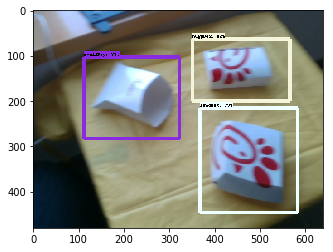

In [30]:
for image_path in image_list:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

## Conclusion

If you want the annotations - you'll find the annotations tarball in data/ directory
use the Notebook browser to download it

The fastest, easiest way to review (and correct / verify) is to use labelImg program which will merge the image and annotation

The main conclusion here is our model works.